In [ ]:
!pip install jiwer

In [ ]:
!pip install gdown

In [ ]:
!pip uninstall keras -y

In [ ]:
!pip install keras==2.15.0

In [ ]:
import keras
print(keras.__version__)

2024-06-18 08:54:20.547845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 08:54:20.548002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 08:54:20.656569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import requests
import tarfile
import os
import zipfile
import tempfile
import json
import librosa
import soundfile as sf
import gdown
import shutil
import csv

## Import LJSpeech Dataset


*   **ID**: this is the name of the corresponding .wav files
*   **Transcription**: words spoken by the reader (UTF-8)
*   **Normalized transcription**: transcription with numbers, ordinals and monetary units expanded into full words (UTF-8).



**Download Weigth Drive**

In [ ]:
url = 'https://drive.google.com/uc?id=1kVlMl51MqQGwWaIRA2M4DaYriK6Stdje'

output = 'checkpoint.weights.h5'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1kVlMl51MqQGwWaIRA2M4DaYriK6Stdje
From (redirected): https://drive.google.com/uc?id=1kVlMl51MqQGwWaIRA2M4DaYriK6Stdje&confirm=t&uuid=322c3279-fd44-4df8-adb2-835a9f4588eb
To: /kaggle/working/checkpoint.weights.h5
100%|██████████| 440M/440M [00:11<00:00, 38.4MB/s] 


'checkpoint.weights.h5'

**Download Dataset LJ & Dataset TalkTales**

In [ ]:
url = 'https://drive.google.com/uc?id=1EgvbUopJDMyU6VHY57ll0w1alr73WOd3'

output = 'TalkTales.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1EgvbUopJDMyU6VHY57ll0w1alr73WOd3
To: /kaggle/working/TalkTales.zip
100%|██████████| 6.52M/6.52M [00:00<00:00, 9.49MB/s]


'TalkTales.zip'

In [ ]:
def extract_zip(zip_file_path, extract_to_path):
    """
    Mengekstrak file ZIP ke direktori tujuan.

    :param zip_file_path: Path ke file ZIP yang akan diekstrak
    :param extract_to_path: Path ke direktori tujuan untuk mengekstrak file
    """
    # Memeriksa apakah file ZIP ada
    if not os.path.exists(zip_file_path):
        print(f"File {zip_file_path} tidak ditemukan.")
        return

    # Membuka file ZIP
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Mengekstrak semua file
        zip_ref.extractall(extract_to_path)
        print(f"File diekstrak ke {extract_to_path}")

# Contoh penggunaan
zip_file_path = '/kaggle/working/TalkTales.zip'
extract_to_path = '/root/.keras/datasets/'
extract_zip(zip_file_path, extract_to_path)

File diekstrak ke /root/.keras/datasets/


In [ ]:
def get_wav_filenames(wav_folder_path):
    """
    Mengambil daftar nama file WAV tanpa ekstensi dari folder yang ditentukan.
    """
    wav_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    return wav_files

def extract_transcription_from_filename(filename):
    """
    Mengekstrak transkripsi dari nama file WAV.
    """
    # Hilangkan ekstensi file .wav
    base_name = os.path.splitext(filename)[0]
    # Pisahkan nama file berdasarkan karakter _
    parts = base_name.split('_')[2:]  # Mengabaikan bagian pertama dan kedua
    # Gabungkan bagian-bagian yang tersisa menjadi satu kalimat
    transcription = ' '.join(parts)
    return transcription, transcription  # Mengembalikan transcription dua kali karena normalized_transcription sama

def create_csv_data(wav_files):
    """
    Membuat data untuk CSV dari nama file WAV dan transkripsi.
    """
    csv_data = []

    for wav_file in wav_files:
        transcription, normalized_transcription = extract_transcription_from_filename(wav_file)
        base_name = os.path.splitext(wav_file)[0]  # Hanya nama file tanpa ekstensi
        csv_data.append([base_name, transcription, normalized_transcription])

    return csv_data

def save_to_csv(csv_data, csv_file_path):
    """
    Menyimpan data ke dalam file CSV.
    """
    headers = ["file_name", "transcription", "normalized_transcription"]

    with open(csv_file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(csv_data)

    print(f"Data disimpan ke {csv_file_path}")

# Path ke folder WAV dan file CSV output
wav_folder_path = '/root/.keras/datasets/TalkTales/'
csv_file_path = '/root/.keras/datasets/TalkTales/talktales.csv'

# Mengambil nama file WAV
wav_files = get_wav_filenames(wav_folder_path)

# Membuat data untuk CSV dan menyimpannya
csv_data = create_csv_data(wav_files)
save_to_csv(csv_data, csv_file_path)

Data disimpan ke /root/.keras/datasets/TalkTales/talktales.csv


In [ ]:
os.remove(zip_file_path)

In [ ]:
talktales_df = pd.read_csv(csv_file_path, sep=",")

In [ ]:
talktales_df.head()

,file_name,transcription,normalized_transcription
0,7_Nicholas_How_could_this_happen,How could this happen,How could this happen
1,26_Dandi_I_lost_my_mother_s_clothes_Grandma_If...,I lost my mother s clothes Grandma If I go hom...,I lost my mother s clothes Grandma If I go hom...
2,30_Faqih_Timun_Mas_you_must_leave_now_Take_thi...,Timun Mas you must leave now Take this bundle ...,Timun Mas you must leave now Take this bundle ...
3,6_Nicholas_I_lost_my_clothes_Hurry_up_and_retu...,I lost my clothes Hurry up and return them I d...,I lost my clothes Hurry up and return them I d...
4,22_Dandi_Please_give_us_a_little_more_time,Please give us a little more time,Please give us a little more time


In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

2748572632/2748572632 [==============================] - 258s 0us/step


In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [ ]:
metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "transcription", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [ ]:
metadata_df.head(3)

,file_name,transcription,normalized_transcription
0,LJ032-0240,"By Sunday, March 31, 1963,","By Sunday, March thirty-one, nineteen sixty-th..."
1,LJ020-0007,Five tablespoonfuls of yeast. One tablespoonfu...,Five tablespoonfuls of yeast. One tablespoonfu...
2,LJ047-0153,Having determined that Mrs. Paine was a respon...,Having determined that Mrs. Paine was a respon...


In [ ]:
def move_wav_files(source_path, wav_dest_path):
    """
    Memindahkan semua file .wav dari direktori sumber ke direktori tujuan.

    :param source_path: Path ke direktori sumber
    :param wav_dest_path: Path ke folder tujuan untuk file .wav
    """
    # Memeriksa apakah folder tujuan untuk file .wav ada, jika tidak, buat folder tersebut
    if not os.path.exists(wav_dest_path):
        os.makedirs(wav_dest_path)

    # Memindahkan file .wav ke folder tujuan
    for root, dirs, files in os.walk(source_path):
        for file in files:
            if file.endswith('.wav'):
                source_file = os.path.join(root, file)
                dest_file = os.path.join(wav_dest_path, file)
                shutil.move(source_file, dest_file)
                print(f"Memindahkan {source_file} ke {dest_file}")

# Contoh penggunaan
source_path = '/root/.keras/datasets/TalkTales/'
wav_dest_path = '/root/.keras/datasets/LJSpeech-1.1/wavs/'
move_wav_files(source_path, wav_dest_path)

Memindahkan /root/.keras/datasets/TalkTales/7_Nicholas_How_could_this_happen.wav ke /root/.keras/datasets/LJSpeech-1.1/wavs/7_Nicholas_How_could_this_happen.wav
Memindahkan /root/.keras/datasets/TalkTales/26_Dandi_I_lost_my_mother_s_clothes_Grandma_If_I_go_home_without_them_I_ll_be_scolded.wav ke /root/.keras/datasets/LJSpeech-1.1/wavs/26_Dandi_I_lost_my_mother_s_clothes_Grandma_If_I_go_home_without_them_I_ll_be_scolded.wav
Memindahkan /root/.keras/datasets/TalkTales/30_Faqih_Timun_Mas_you_must_leave_now_Take_this_bundle_Inside_are_items_that_can_help_you_escape_from_the_raksasa.wav ke /root/.keras/datasets/LJSpeech-1.1/wavs/30_Faqih_Timun_Mas_you_must_leave_now_Take_this_bundle_Inside_are_items_that_can_help_you_escape_from_the_raksasa.wav
Memindahkan /root/.keras/datasets/TalkTales/6_Nicholas_I_lost_my_clothes_Hurry_up_and_return_them_I_don't_have_time_for_this_nonsense.wav ke /root/.keras/datasets/LJSpeech-1.1/wavs/6_Nicholas_I_lost_my_clothes_Hurry_up_and_return_them_I_don't_have_t

In [ ]:
metadata_df = pd.concat([metadata_df, talktales_df], ignore_index=True)
metadata_df.to_csv(metadata_path, index=False)

In [ ]:
metadata_df = pd.read_csv(metadata_path, sep=",")

In [ ]:
metadata_df.tail()

,file_name,transcription,normalized_transcription
13137,25_Dandi_Yes_and_also_make_sure_dinner_is_read...,Yes and also make sure dinner is ready when we...,Yes and also make sure dinner is ready when we...
13138,12_Rafli_I_lost_my_mother's_clothes_Grandma_If...,I lost my mother's clothes Grandma If I go hom...,I lost my mother's clothes Grandma If I go hom...
13139,14_Rafli_How_could_this_happen,How could this happen,How could this happen
13140,29_Faqih_Please_give_us_a_little_more_time,Please give us a little more time,Please give us a little more time
13141,37_Luthfi_Timun_Mas_you_must_leave_now_Take_th...,Timun Mas you must leave now Take this bundle ...,Timun Mas you must leave now Take this bundle ...


In [ ]:
metadata_df.head()

,file_name,transcription,normalized_transcription
0,LJ032-0240,"By Sunday, March 31, 1963,","By Sunday, March thirty-one, nineteen sixty-th..."
1,LJ020-0007,Five tablespoonfuls of yeast. One tablespoonfu...,Five tablespoonfuls of yeast. One tablespoonfu...
2,LJ047-0153,Having determined that Mrs. Paine was a respon...,Having determined that Mrs. Paine was a respon...
3,LJ008-0269,"Already the severity of our criminal code, and...","Already the severity of our criminal code, and..."
4,LJ008-0097,"No sooner was the ""job"" finished than half-a-d...","No sooner was the ""job"" finished than half-a-d..."


Split the data into training and validation set

In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 11827
Size of the validation set: 1315


# Augmentasi Data

In [ ]:
wavs_path

'/root/.keras/datasets/LJSpeech-1.1/wavs/'

In [ ]:
# Fungsi untuk melakukan augmentasi dan menyimpan hasilnya
def augment_and_save(file_path, output_dir, metadata_df):
    y, sr = librosa.load(file_path, sr=None)

    # Mengubah pitch
    y_pitch_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=3)
    y_pitch_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-3)
    # Menambahkan noise
    noise_amp = 0.05 * np.random.uniform() * np.amax(y)
    y_noisy = y + noise_amp * np.random.normal(size=y.shape)

    # Menyimpan hasil augmentasi dengan suffix yang sesuai
    base_name = os.path.basename(file_path)
    name, ext = os.path.splitext(base_name)

    # Mengubah nama file untuk setiap augmentasi
    augmented_files = {
        "pitchup": (y_pitch_up, f"{name}_pitchup{ext}"),
        "pitchdown": (y_pitch_down, f"{name}_pitchdown{ext}"),
        "noisy": (y_noisy, f"{name}_noisy{ext}")
    }

    for key, (y_aug, augmented_file_name) in augmented_files.items():
        augmented_file_path = os.path.join(output_dir, augmented_file_name)
        sf.write(augmented_file_path, y_aug, sr)
        # Tambahkan baris baru ke DataFrame metadata_df
        add_augmented_row(name, augmented_file_name, metadata_df)

# Fungsi untuk menambahkan baris baru ke DataFrame
def add_augmented_row(original_name, augmented_file_name, metadata_df):
    original_row = metadata_df.loc[metadata_df['file_name'] == original_name]
    new_row = {
        'file_name': augmented_file_name,
        'transcription': original_row['transcription'].values[0],
        'normalized_transcription': original_row['normalized_transcription'].values[0]
    }
    metadata_df.loc[len(metadata_df)] = new_row

# Direktori input dan output
input_dir = "/root/.keras/datasets/LJSpeech-1.1/wavs/"  # Ganti dengan direktori input Anda
output_dir = "/root/.keras/datasets/LJSpeech-1.1/aug/"  # Ganti dengan direktori output Anda
os.makedirs(output_dir, exist_ok=True)


# Memproses semua file dalam direktori input
for file_name in os.listdir(input_dir):
    if file_name.endswith(".wav"):  # Sesuaikan dengan ekstensi audio yang diinginkan
        file_path = os.path.join(input_dir, file_name)
        augment_and_save(file_path, output_dir, metadata_df)

# Menyimpan kembali metadata yang sudah diperbarui
metadata_df.to_csv(metadata_path, index=False)

print("Proses augmentasi selesai.")

Proses augmentasi selesai.


In [ ]:
metadata_df.tail()

,file_name,transcription,normalized_transcription
52563,LJ031-0089_pitchdown.wav,considerable time which at this juncture was n...,considerable time which at this juncture was n...
52564,LJ031-0089_noisy.wav,considerable time which at this juncture was n...,considerable time which at this juncture was n...
52565,LJ008-0145_pitchup.wav,"They were accused by a confederate, who, goade...","They were accused by a confederate, who, goade..."
52566,LJ008-0145_pitchdown.wav,"They were accused by a confederate, who, goade...","They were accused by a confederate, who, goade..."
52567,LJ008-0145_noisy.wav,"They were accused by a confederate, who, goade...","They were accused by a confederate, who, goade..."


In [ ]:
# Direktori input dan output
input_dir = "/root/.keras/datasets/LJSpeech-1.1/wavs/"  # Ganti dengan direktori input Anda
output_dir = "/root/.keras/datasets/LJSpeech-1.1/aug/"  # Ganti dengan direktori output Anda

# Membuat direktori input jika belum ada
os.makedirs(input_dir, exist_ok=True)

# Memindahkan semua file dari output_dir ke input_dir
for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)
    if os.path.isfile(file_path):  # Pastikan hanya memindahkan file
        shutil.move(file_path, input_dir)

print("Semua file telah dipindahkan dari output_dir ke input_dir.")

Semua file telah dipindahkan dari output_dir ke input_dir.


## Preprocessing

Prepare the vocabulary to be used.

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters into integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size = 31)


Create the function that describes the transformation that we apply to each element of our dataset.

In [ ]:
char_to_num

# **STFT + MFCC Feature Extraction**

In [ ]:
# An integer scalar Tensor. The window length is samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
  ###############################
  ## Process the audio
  ###############################
  # 1. Read wav file
  audio_binary = tf.io.read_file(wavs_path + wav_file + ".wav")
  audio, _ = tf.audio.decode_wav(audio_binary)
  audio = tf.squeeze(audio, axis=-1)

  # 2. Get the mel spectrogram
  stft = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
  spectrogram = tf.abs(stft)
  mel_spectrogram = tf.tensordot(spectrogram, tf.signal.linear_to_mel_weight_matrix(num_mel_bins=193, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000), 1)
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

  # 3. Normalization
  means = tf.math.reduce_mean(log_mel_spectrogram, axis=1, keepdims=True)
  stddevs = tf.math.reduce_std(log_mel_spectrogram, axis=1, keepdims=True)
  normalized_mel_spectrogram = (log_mel_spectrogram - means) / (stddevs + 1e-10)

  ###########################
  ## Process the Label
  ###########################
  # 4. Convert label to Lower case
  label = tf.strings.lower(label)
  # 5. Split the label
  label = tf.strings.unicode_split(label,input_encoding="UTF-8")
  # 6. Map the characters in label to numbers
  label = char_to_num(label)
  # 7. Return a dict as our model is expecting two inputs
  return normalized_mel_spectrogram, label

## Creating Dataset objects
We create a tf.data.Dataset pbject that yields the transofrmed elements, in the same order as they appeared in the input.

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

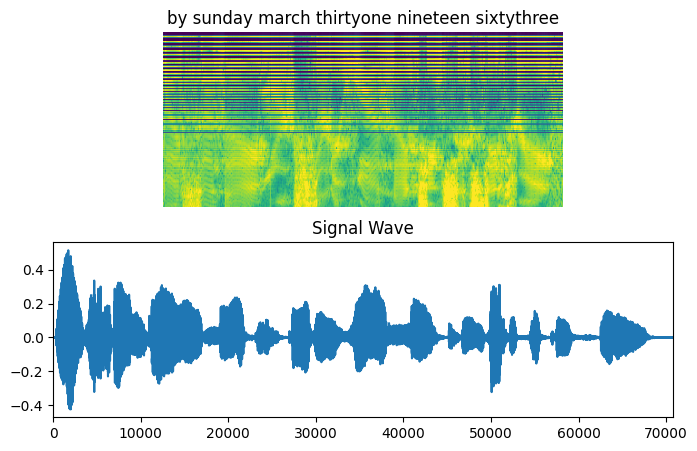

In [ ]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  # Spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  # WAV
  file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0]+ ".wav")
  audio,_ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate = 16000))
plt.show()

## Model

In [ ]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

Define model similar to DeepSpeech2.

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=7, rnn_units=128):
  input_spectogram = layers.Input((None, input_dim))
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
  # Convlutional layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  # Convlutional layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1,2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  # Convlutional layer 3
  x = layers.Conv2D(
      filters=64,
      kernel_size=[11, 21],
      strides=[1,2],
      padding="same",
      use_bias=False,
      name="conv_3",
  )(x)
  x = layers.BatchNormalization(name="conv_3_bn")(x)
  x = layers.ReLU(name="conv_3_relu")(x)
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  # RNN Layer
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)
  # Dense Layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  # classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
  # model
  model = keras.Model(input_spectogram, output, name="DeepSpeech2")
  # optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  # compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_1 (InputLayer)                            [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                      

## Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  # bisa pakai beam search juga --> untuk complex tasks
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
  # iterate over the results and get back the text
  output_text = []
  for result in results:
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch: int, logs=None):
    predictions = []
    targets = []
    for batch in self.dataset:
      x, y = batch
      batch_predictions = model.predict(x)
      batch_predictions = decode_batch_prediction(batch_predictions)
      predictions.extend(batch_predictions)
      for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
      print(f"Target    : {targets[i]}")
      print(f"Prediction: {predictions[i]}")
      print("-" * 100)

In [ ]:
# Specify the path where you want to save the model
checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
epochs = 100
validation_callback = CallbackEval(validation_dataset)

if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)
    print("Loaded weights from checkpoint")
else:
    print("No checkpoint found. Starting from scratch.")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint_callback],
)

Loaded weights from checkpoint
Epoch 1/100


I0000 00:00:1718703653.721690     195 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2008
----------------------------------------------------------------------------------------------------
Target    : that we encourage the retirement of elderly judges by offering them a life pension at full salary
Prediction: that we incurage the retirement of elderly judges by offering them a life pension at full saary
----------------------------------------------------------------------------------------------------
Target    : oswald said that he hoped eventually to develop qualifications for employment as a junior executive
Prediction: oswald said that he hoped deventually to develocqualifications for employment as ajunor executive
----------------------------------------------------------------------------------------------------
370/370 [==============================] - 2433s 6s/step - loss: 34.2925 - val_los

## Inference

In [ ]:
# check results of validation samples
predictions = []
targets = []
for batch in validation_dataset:
  X, y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_prediction(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 2):
  print(f"Target    : {targets[i]}")
  print(f"Prediction: {predictions[i]}")
  print("-" * 100)

# Model To JSON

In [ ]:
saved_model_path = "/kaggle/working/capstone_model_fix_greedy.h5"

model.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} /kaggle/working

# Save Model

In [ ]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

# Examine Your Saved Model

In [ ]:
!saved_model_cli show --dir {export_path} --all

# Add TensorFlow Serving Distribution URI as a Package Source

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

# Install Tensorflow Serving

In [ ]:
!apt-get install tensorflow-model-server

# Run the TensorFlow Model Server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=speech_to_text \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

# Create JSON Object with Test Images

In [ ]:
for spectograms, labels in validation_dataset.take(1):
    # Mengonversi tensor ke list
    spectograms_list = spectograms.numpy().tolist()
    labels_list = labels.numpy().tolist()

In [ ]:
data = {
        "signature_name": "serving_default",
        "instances": spectograms_list,
        "labels": labels_list
    }

In [ ]:
json_data = json.dumps(data)

# Make Inference Request

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://192.168.1.1:8501/v1/models/digits_model:predict', data=json_data, headers=headers)

predictions = json.loads(json_response.text)['predictions']